In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from analysis_utils import get_run_data, process_run_data, add_significance_marks, aggregate_metrics, METRIC_NAMES

In [2]:
data, config = get_run_data("eli-carrami/Cprt-Paper-Exp-0")
out = []
best_basis = "biochem/val_kingdom_f1"
use_last = True
for d, c in zip(data, config):
    llm = c['model']['value']['language_model']
    if 'gpt' in llm:
        h = d.iloc[-1].copy()
    elif use_last:
        d = d[d.epoch == 0]
        h = d.iloc[-1].copy()
    else:
        h = d.iloc[d[best_basis].idxmax()].copy()
    h['protein_layer_to_use'] = c['model']['value']['protein_layer_to_use']
    h['protein_layer_to_use'] = -1 if h['protein_layer_to_use'] == 12 else h['protein_layer_to_use']
    h['llm'] = llm
    h['strategy'] = c['model']['value']['multimodal_strategy']
    h['seed'] = c['seed']['value']
    out.append(h)

frosty-wildflower-63 glad-totem-62 northern-galaxy-53 dauntless-surf-44 confused-lion-43 snowy-sun-42 exalted-pyramid-41 major-puddle-40 earthy-planet-39 stoic-dragon-38 astral-salad-37 balmy-gorge-36 peach-vortex-35 quiet-wind-34 jumping-bush-33 visionary-bee-32 northern-lake-32 legendary-glitter-15 wobbly-firefly-31 expert-paper-30 golden-firebrand-28 comic-puddle-27 magic-surf-26 chocolate-fog-25 noble-feather-24 different-elevator-19 vivid-lake-18 toasty-snow-17 copper-jazz-16 breezy-violet-7 amber-cherry-15 laced-leaf-14 snowy-puddle-13 smart-flower-12 glowing-haze-11 hardy-butterfly-9 effortless-surf-8 solar-star-6 flowing-frog-5 

In [3]:
layer_order = ["wte", -1]
var = 'protein_layer_to_use'

fltr = [('strategy', "soft-prompt"), ('llm', "microsoft/phi-2")]
ordering = (var, layer_order)
df = process_run_data(out, fltr, ordering)

In [4]:
metrics_names = {k:v for k, v in METRIC_NAMES.items() if 'rouge' not in k}
agg_df = aggregate_metrics(df, group_by=var)
agg_df = agg_df[[col for col in metrics_names]]

for col, name in metrics_names.items():
    agg_df[name] = round(agg_df[(col, 'mean')], 2).astype(str) + " (" + round(agg_df[(col, 'std')], 2).astype(str) + ")"
    agg_df.drop([(col, 'mean'), (col, 'std')], axis=1, inplace=True)

agg_df.to_clipboard()
agg_df

/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(['mean', 'std'])


,is_real F1,is_enzyme F1,kingdom F1,localization F1,cofactor Recall,binary localization\naverage F1,is_fake F1,MW MALE,perplexity,in_membrane F1,in_nucleus F1,in_mitochondria F1
,,,,,,,,,,,,
protein_layer_to_use,,,,,,,,,,,,
wte,0.44 (0.09),0.72 (0.01),0.15 (0.13),0.45 (0.02),0.2 (0.06),0.15 (0.04),0.36 (0.04),0.03 (0.01),2.24 (0.01),0.19 (0.01),0.21 (0.13),0.06 (0.04)
-1,0.99 (0.01),0.89 (0.01),0.8 (0.03),0.71 (0.04),0.58 (0.03),0.39 (0.04),0.6 (0.28),0.03 (0.01),1.92 (0.02),0.27 (0.04),0.65 (0.05),0.24 (0.04)


/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(['mean', 'std'])
/var/folders/nv/z1jxx0450bl2tkfsvqfvmzz00000gn/T/ipykernel_39636/3803528784.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  x.set_xticklabels(metric_names[idx], fontsize=label_size)
/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(['mean', 'std'])
/var/

wte 12 biochem/val_is_real_f1 0.0034847435398090818 -11.915717782154482
wte 12 biochem/val_is_enzyme_f1 0.005922551068401343 -9.106374606318113
wte 12 biochem/val_kingdom_f1 0.012408177337764113 -6.2291483340830816
wte 12 biochem/val_localization_f1 0.004011686281411819 -11.096750941912354
wte 12 biochem/val_cofactor 0.019052325673005674 -4.9752614471718815
wte 12 avg_binary_loc_f1 0.9737926732283917 4.194292608488307
wte 12 biochem/val_is_fake_f1 0.9717747871228251 4.028545736601508
wte 12 biochem/val_mw_error 0.3135275901807869 0.5684341423063669
wte 12 metrics/val_rouge1_fmeasure 0.24377778551361629 -0.8439369442488922
wte 12 metrics/val_rouge1_precision 0.3011367251245666 -0.6130439542896516
wte 12 metrics/val_rouge1_recall 0.16358211615964485 -1.2862177730485391
wte 12 metrics/val_rouge2_fmeasure 0.1635476209639221 -1.286458780339258
wte 12 metrics/val_rouge2_precision 0.23390029235098758 -0.8889991886815716
wte 12 metrics/val_rouge2_recall 0.00816923538020534 -7.727182978564776
w

Text(6.0, 0.51, 'random guess')

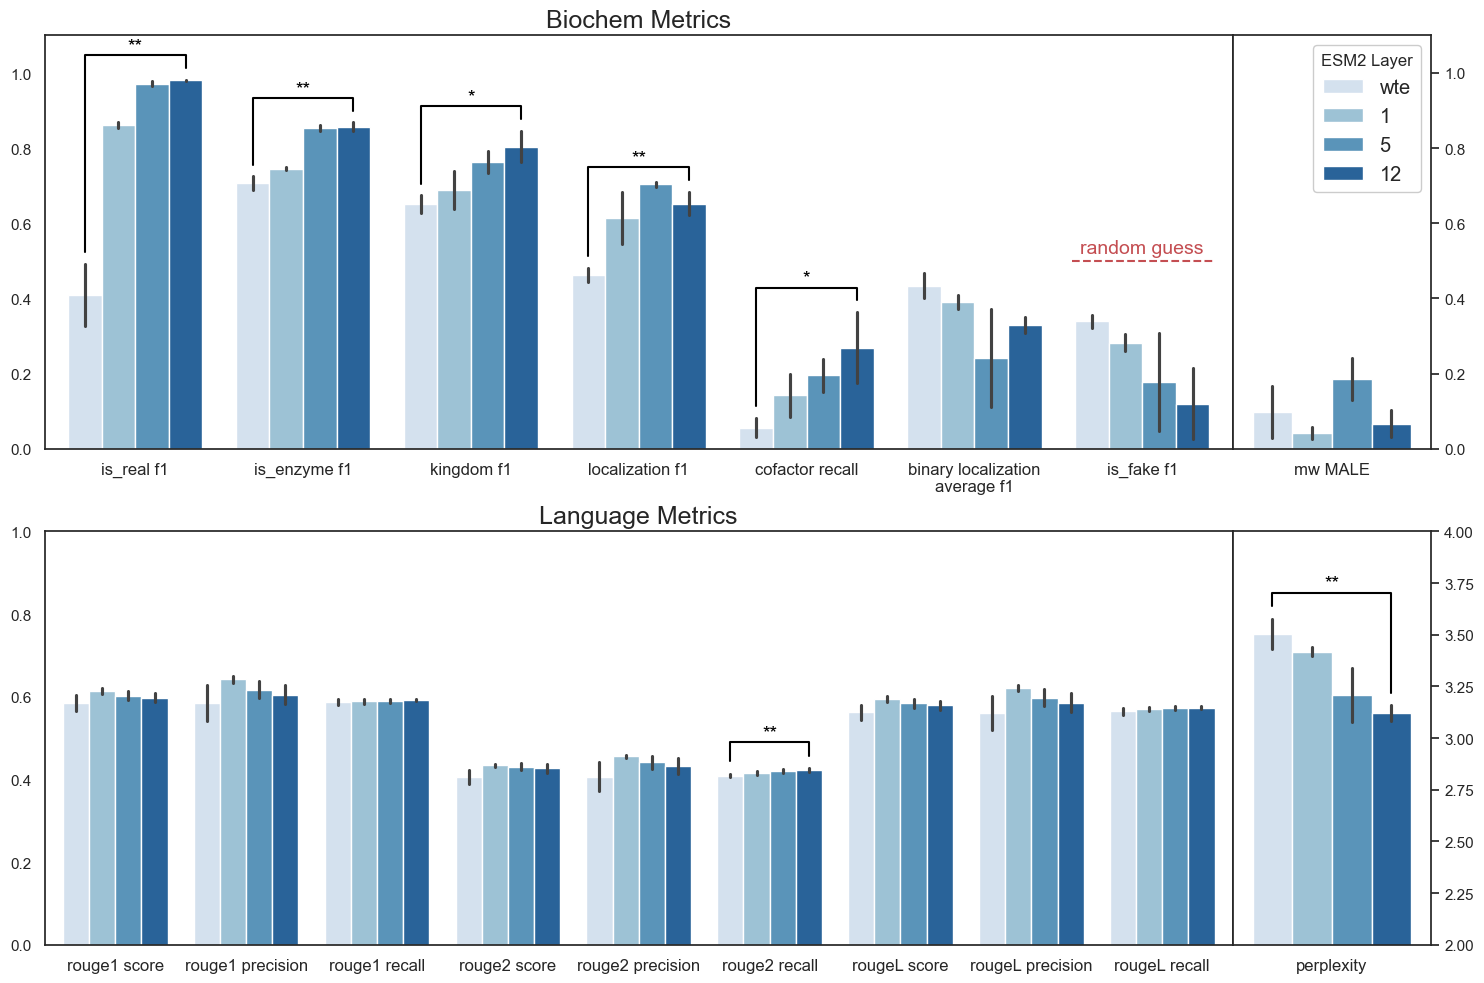

In [122]:
sns.set(style="white")
label_size=12

plot_configs = {
    "palette": sns.color_palette("Blues", len(layer_order)),
    "x": 'variable', "y": 'value', "errorbar": 'sd', "hue": var
}

df_melted = df.melt(id_vars=var, value_vars=df.columns.drop(var))


fig = plt.figure(figsize=(15, 10))
ax0 = plt.subplot2grid((2, 7), (0, 0), colspan=6, fig=fig)
ax1 = plt.subplot2grid((2, 7), (0, 6), colspan=1, fig=fig)
ax2 = plt.subplot2grid((2, 7), (1, 0), colspan=6, fig=fig)
ax3 = plt.subplot2grid((2, 7), (1, 6), colspan=1, fig=fig)

ax1.set_ylim([0, 1.1])
ax1.set_ylim([0, 1.1])
ax2.set_ylim([0, 1])
ax3.set_ylim([2, 4])

for idx, x in enumerate([ax0, ax1, ax2, ax3]):
    sns.barplot(data=df_melted[df_melted['variable'].isin(metric_groups[idx])], ax=x, order=metric_groups[idx], **plot_configs)
    add_significance_marks(x, df, var, metric_groups[idx], layer_order, metric_mode[idx])
    x.set_xticklabels(metric_names[idx], fontsize=label_size)
    x.set_xlabel('')
    x.set_ylabel('')

ax0.set_ylabel

ax0.legend().remove()
leg = ax1.legend(title='ESM2 Layer', loc='upper right', fontsize='large')
leg.get_frame().set_alpha(1)
ax2.legend().remove()
ax3.legend().remove()

ax1.yaxis.tick_right()
ax3.yaxis.tick_right()
ax0.set_title('Biochem Metrics', fontsize=18)
ax2.set_title('Language Metrics', fontsize=18)

fig.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=0)
l, r = ax2.get_xlim()
ax2.set_xlim([l+0.3, r-0.3])
l, r = ax0.get_xlim()
ax0.set_xlim([l+0.2, r-0.2])
ax3.set_xlim(ax1.get_xlim())

x1 = ax0.patches[len(metric_groups[0]) - 1].get_x() - 0.02
x2 = ax0.patches[len(metric_groups[0]) * len(layer_order) - 1].get_x() +ax0.patches[27].get_width() + 0.02
ax0.plot([x1, x2], [0.5, 0.5], 'r--', lw=1.5)
ax0.text((x1 + x2) / 2, 0.51, "random guess", ha='center', va='bottom', fontsize=14, color='r')

# plt.savefig("soft_metrics.png")

In [132]:
metrics = {
    'biochem/val_is_real_f1': 'is_real F1',
    'biochem/val_is_enzyme_f1': 'is_enzyme F1',
    'biochem/val_kingdom_f1': 'kingdom F1',
    'biochem/val_localization_f1': 'localization F1',
    'biochem/val_cofactor': 'cofactor Recall',
    'avg_binary_loc_f1': 'binary localization\naverage F1',
    'biochem/val_is_fake_f1': 'is_fake F1',
    'biochem/val_mw_error': 'MW MALE',
    'metrics/val_perplexity': 'perplexity',
    'metrics/val_rouge1_fmeasure': 'rouge1 Score',
    'metrics/val_rouge1_precision': 'rouge1 Precision',
    'metrics/val_rouge1_recall': 'rouge1 Recall',
    'metrics/val_rouge2_fmeasure': 'rouge2 Score',
    'metrics/val_rouge2_precision': 'rouge2 Precision',
    'metrics/val_rouge2_recall': 'rouge2 Recall',
    'metrics/val_rougeL_fmeasure': 'rougeL Score',
    'metrics/val_rougeL_precision': 'rougeL Precision',
    'metrics/val_rougeL_recall': 'rougeL Recall'
}
ylims = {k: [0, 1] for k in metrics}
modes = {k: "min" if any([h in k for h in ["perplexity", "error"]]) else "max" for k in metrics}

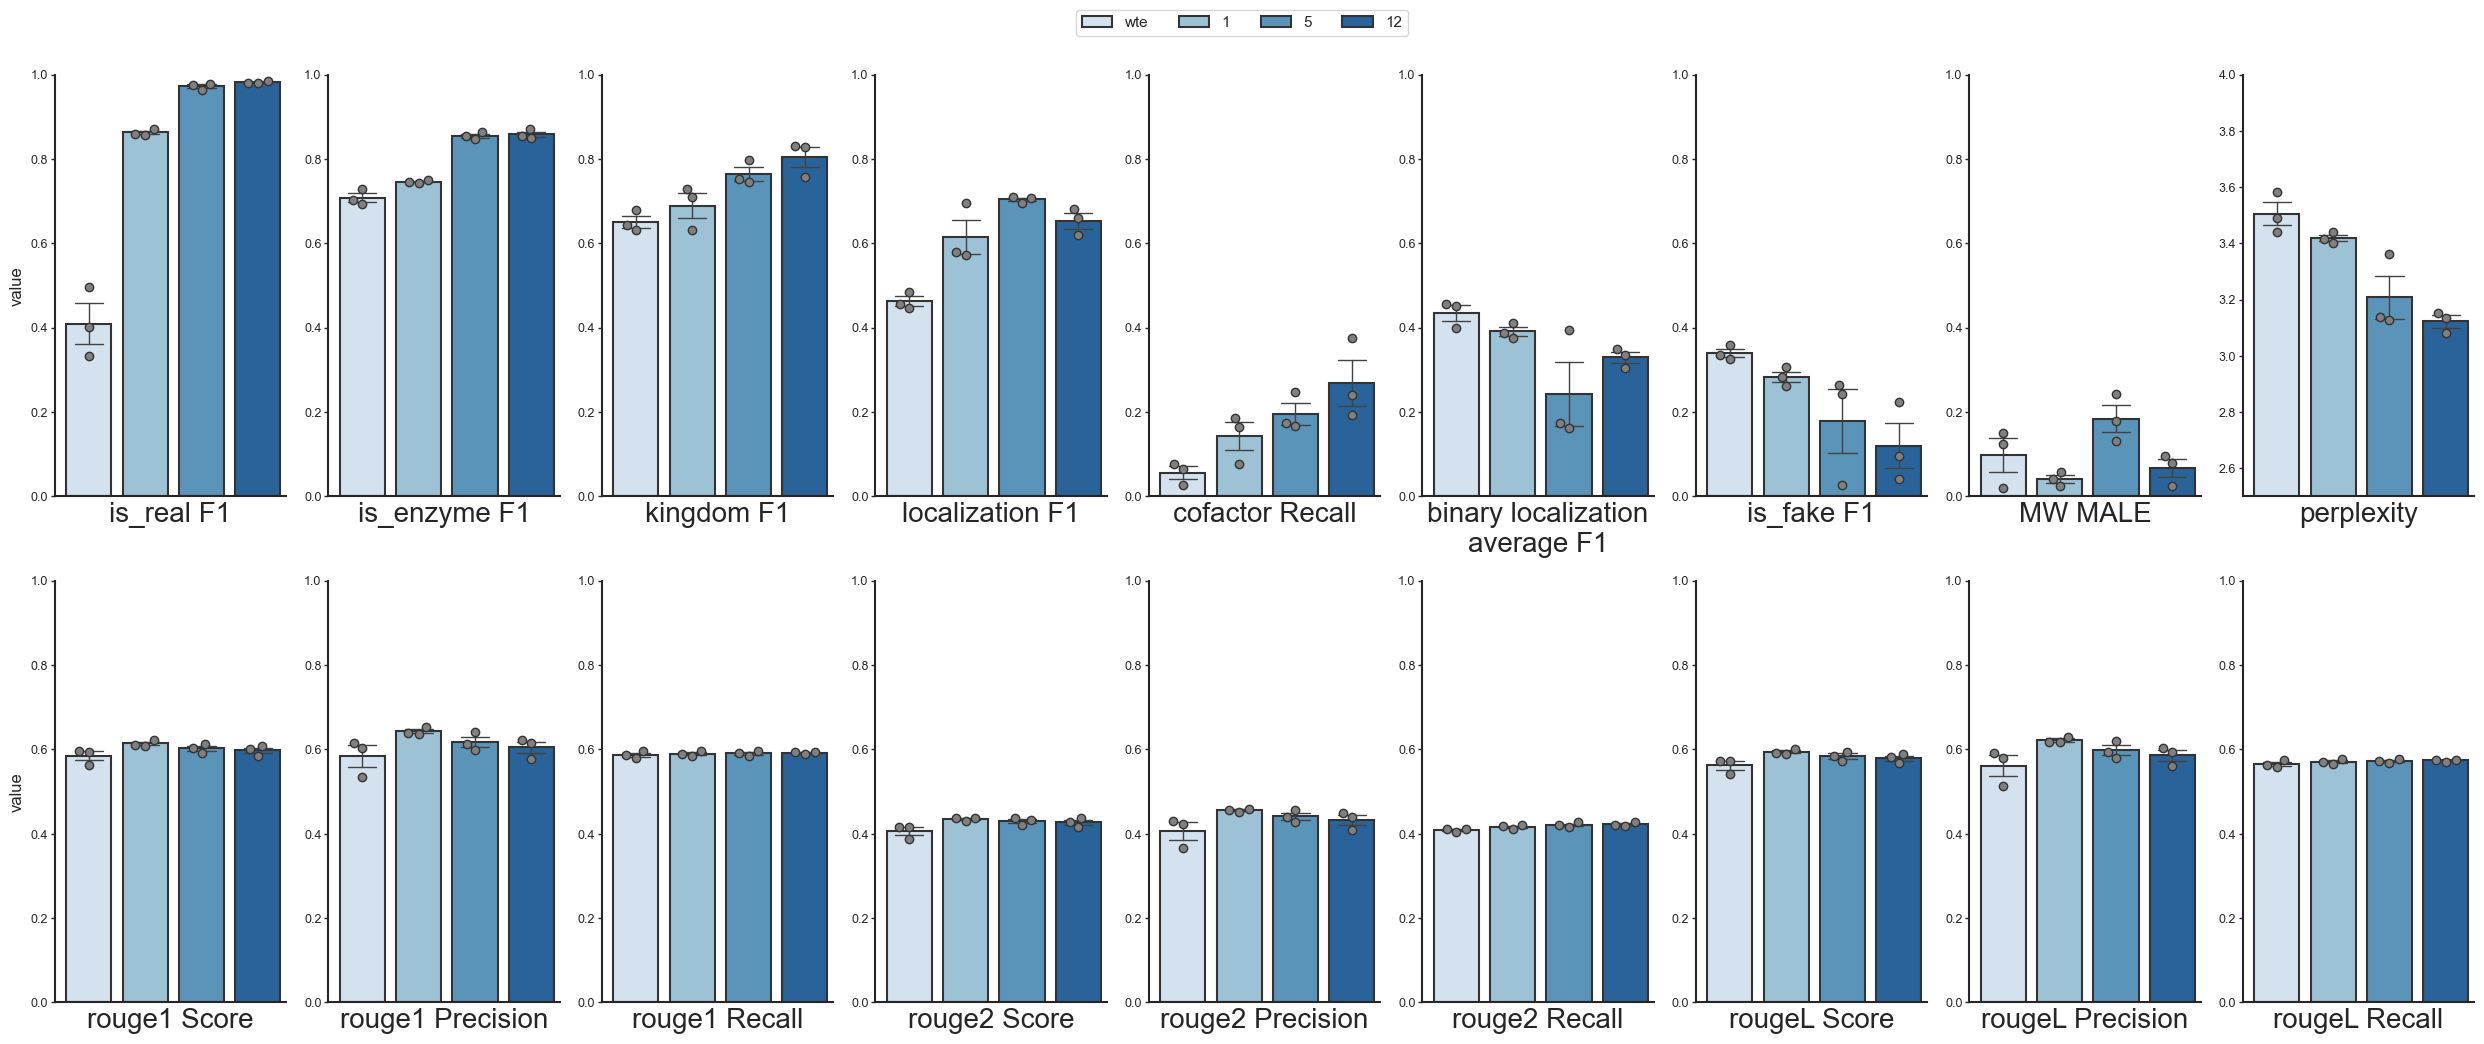

In [136]:
import warnings
warnings.filterwarnings('once')

sns.set(style="white")
label_size=12

plot_configs = {
    "palette": sns.color_palette("Blues", len(layer_order)),
    "errorbar": 'se', "err_kws": {'linewidth': 1}, "capsize":0.5, "edgecolor":'0.2', "lw":1.5
}

df_melted = df.melt(id_vars=var, value_vars=df.columns.drop(var))

fig, axes = plt.subplots(2, 9, figsize=(25, 10))

ylims.update({'metrics/val_perplexity': [2.5, 4]})

for i, (m, ax) in enumerate(zip(metrics, axes.flatten())):
    _df = df_melted[df_melted['variable'] == m]
    sns.barplot(x=_df[var], y=_df['value'], hue=_df[var], ax=ax, **plot_configs)
    sns.swarmplot(x=_df[var], y=_df['value'], s=6, edgecolor='0.2', fc='grey', linewidth=1, ax=ax)

    ax.set_xlabel(metrics[m], fontsize=20)
    ax.set_xticks([])
    if i % 9 != 0:
        ax.set_ylabel('')

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-0.6, None)
    ax.set_ylim(ylims[m])

    ax.tick_params(axis='y', which='major', labelsize=9, pad=2)
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_tick_params(length=3, width=1)
    ax.get_legend().remove()

plt.subplots_adjust(hspace=0.5)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.savefig("test.png")